## Calculation of Markers


Tâche 1: 3971 points entre 0.00s et 20.00s


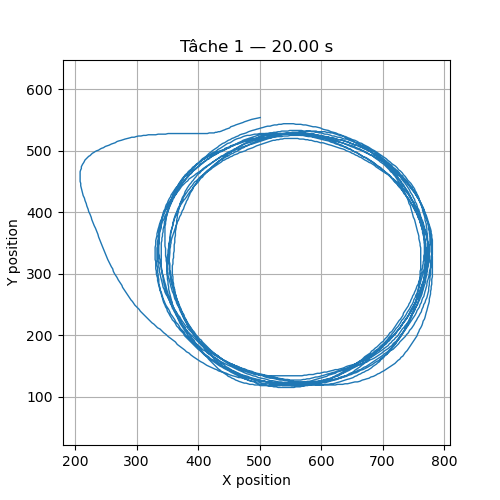


Tâche 2: 3898 points entre 40.01s et 60.02s


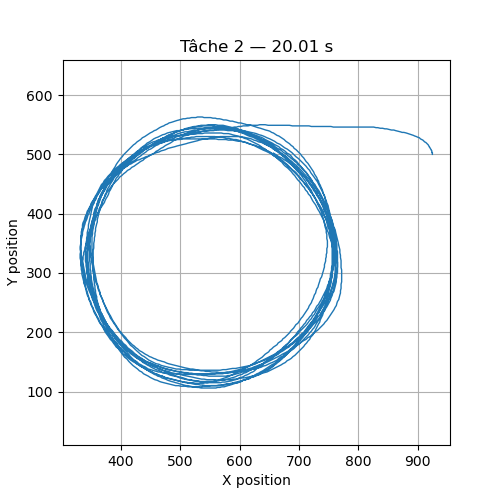


Tâche 3: 3898 points entre 80.04s et 100.05s


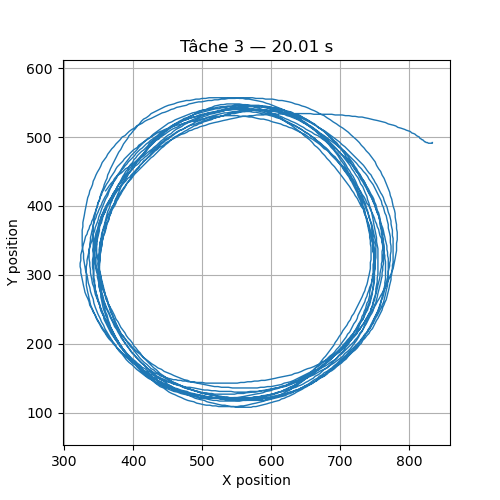


Tâche 4: 3884 points entre 120.06s et 140.07s


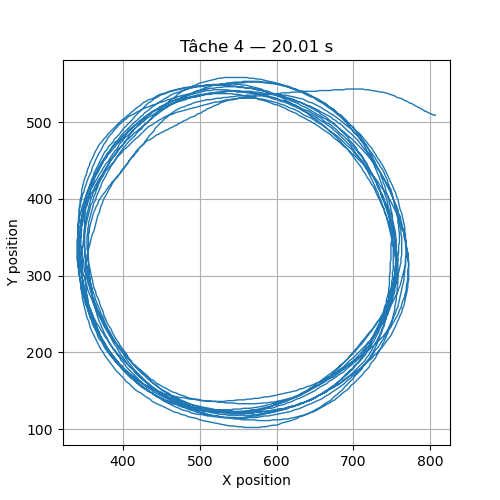


Tâche 5: 3936 points entre 160.09s et 180.10s


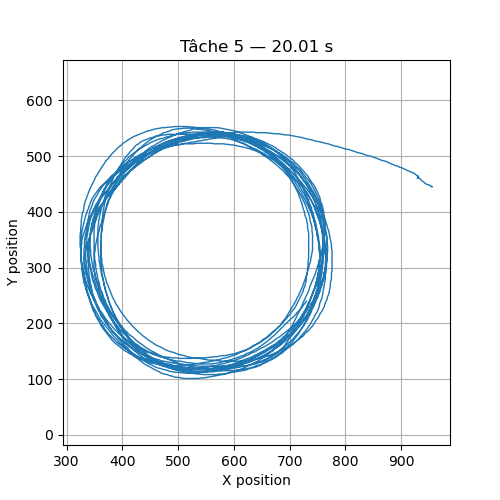

In [42]:
import csv
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Fichiers ---
data_path = "/Users/matysprecloux/Desktop/Master IEAP/IEAP-project/Circular-task-analysis:/Data/001MoDe_R1.csv"
marker_path = "/Users/matysprecloux/Desktop/Master IEAP/IEAP-project/Circular-task-analysis:/Data/001MoDe_R1.marker.csv"

# --- 2. Lecture des marqueurs ---
with open(marker_path, "r") as f:
    lines = f.readlines()

record_start = []
record_end = []

for line in lines:
    parts = line.strip().split(",")
    if len(parts) < 3:
        continue
    try:
        ts = int(parts[1])
    except ValueError:
        continue

    if "DoCycleChange:DoRecord" in line:
        record_start.append(ts)
    elif "DoCycleChange:DoPause" in line:
        record_end.append(ts)

if len(record_start) == 0 or len(record_end) == 0:
    raise ValueError("Aucun événement détecté dans le fichier .marker.csv")

# Normalisation du temps
t0 = min(record_start + record_end)
start_record = [(t - t0) / 1000.0 for t in record_start]
stop_record = [(t - t0) / 1000.0 for t in record_end]

# --- 3. Lecture du fichier principal (positions souris) ---
timestamps = []
mouseX = []
mouseY = []

with open(data_path, "r") as f:
    reader = csv.reader(f, delimiter=';')
    rows = list(reader)

for r in rows:
    if len(r) >= 1 and ',' in r[0]:
        parts = r[0].split(',')
        if len(parts) >= 3:
            try:
                t = float(parts[0])
                x = float(parts[1])
                y = float(parts[2])
                timestamps.append(t)
                mouseX.append(x)
                mouseY.append(y)
            except ValueError:
                pass

# Convertir en arrays numpy
timestamps = np.array(timestamps)
mouseX = np.array(mouseX)
mouseY = np.array(mouseY)

# --- 4. Normalisation du temps principal ---
timestamps = (timestamps - timestamps[0]) / 1000.0  # passage en secondes

# --- 5. Découpage des tâches selon les périodes record ---
for i, (start, end) in enumerate(zip(start_record, stop_record), start=1):
    mask = (timestamps >= start) & (timestamps <= end)
    x_task = mouseX[mask]
    y_task = mouseY[mask]
    t_task = timestamps[mask]

    # Print pour contrôle
    print(f"\nTâche {i}: {len(x_task)} points entre {start:.2f}s et {end:.2f}s")

    # --- Graphe ---
    plt.figure(figsize=(5,5))
    plt.plot(x_task, y_task, '-', linewidth=1)
    plt.title(f"Tâche {i} — {end - start:.2f} s")
    plt.xlabel("X position")
    plt.ylabel("Y position")
    plt.axis("equal")  # cercle bien rond
    plt.grid(True)
    plt.show()

In [44]:
marker = "/Users/matysprecloux/Desktop/Master IEAP/IEAP-project/Circular-task-analysis:/Data/001MoDe_R1.marker.csv"

# --- Lecture du fichier ---
with open(marker, "r") as f:
    lines = f.readlines()

record_start = []
record_end = []
timestamp_all = []

# --- Extraction des timestamps ---
for line in lines:
    parts = line.strip().split(",")
    if len(parts) < 3:
        continue 
    try:
        ts = int(parts[1])     
        timestamp_all.append(ts)   
    except ValueError:
        continue 

    if "DoCycleChange:DoRecord" in line:
        record_start.append(ts)
    elif "DoCycleChange:DoPause" in line:
        record_end.append(ts)

# --- Vérifications ---
if len(record_start) == 0:
    raise ValueError("Aucun événement 'DoRecord' détecté dans le fichier.")
if len(record_end) == 0:
    raise ValueError("Aucun événement 'DoPause' détecté dans le fichier.")
if len(record_start) != len(record_end):
    print("⚠️ Attention : nombre de débuts et de fins différents. Vérifie le log.")

# --- Normalisation du temps ---
t0 = min(record_start + record_end)
start_record = [(t - t0) / 1000.0 for t in record_start]
stop_record = [(t - t0) / 1000.0 for t in record_end]

# --- Calcul des durées pour chaque tâche ---
task_durations = []
for start, end in zip(start_record, stop_record):
    duration = end - start
    task_durations.append(duration)

# --- Affichage ---
print("Start times (s):", start_record)
print("End times (s):", stop_record)
print("Durations (s):", task_durations)

# Optionnel : résumé propre
print("\nRésumé des tâches :")
for i, (start, end, dur) in enumerate(zip(start_record, stop_record, task_durations), start=1):
    print(f"Tâche {i}: début = {start:.2f}s, fin = {end:.2f}s, durée = {dur:.2f}s")

Start times (s): [0.0, 40.007, 80.039, 120.057, 160.086]
End times (s): [20.003, 60.018, 100.053, 140.071, 180.1]
Durations (s): [20.003, 20.011000000000003, 20.013999999999996, 20.013999999999996, 20.01399999999998]

Résumé des tâches :
Tâche 1: début = 0.00s, fin = 20.00s, durée = 20.00s
Tâche 2: début = 40.01s, fin = 60.02s, durée = 20.01s
Tâche 3: début = 80.04s, fin = 100.05s, durée = 20.01s
Tâche 4: début = 120.06s, fin = 140.07s, durée = 20.01s
Tâche 5: début = 160.09s, fin = 180.10s, durée = 20.01s


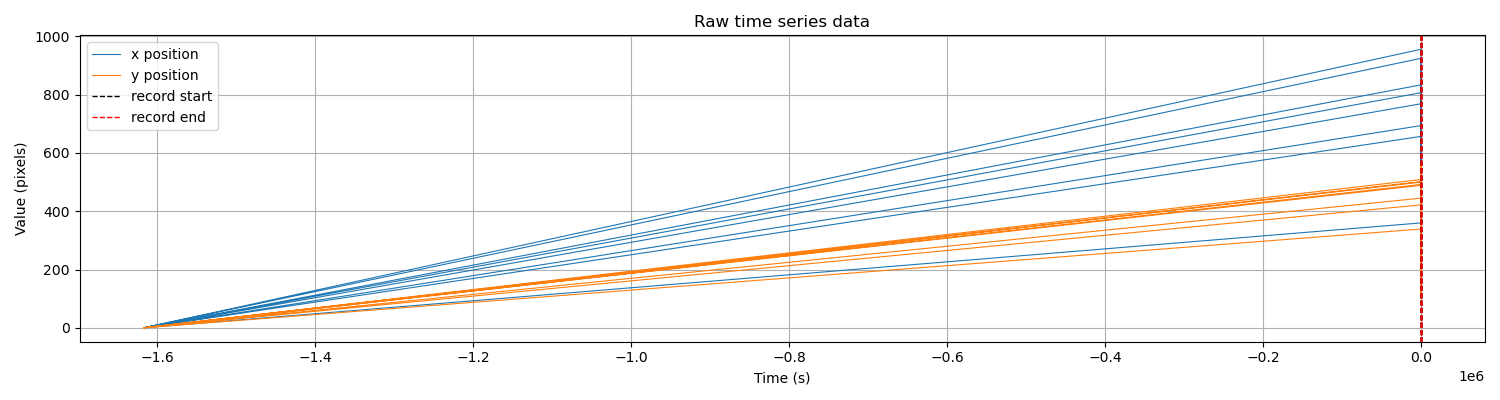

In [55]:
# --- alignement temporel ---
start_record = np.array(start_record) - start_record[0]
stop_record = np.array(stop_record) - start_record[0]
time = (timestamps - timestamps[0]) / 1000.0

# --- vérif des longueurs ---
min_len = min(len(time), len(mouseX), len(mouseY))
time, mouseX, mouseY = time[:min_len], mouseX[:min_len], mouseY[:min_len]

# --- tracé ---
plt.figure(figsize=(15, 4))
plt.plot(time, mouseX, '-', lw=0.8, color='tab:blue', label='x position')
plt.plot(time, mouseY, '-', lw=0.8, color='tab:orange', label='y position')

for s in start_record:
    plt.axvline(s, color='k', ls='--', lw=1, label='record start' if s==start_record[0] else None)
for e in stop_record:
    plt.axvline(e, color='r', ls='--', lw=1, label='record end' if e==stop_record[0] else None)

plt.title("Raw time series data")
plt.xlabel("Time (s)")
plt.ylabel("Value (pixels)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [43]:
# --- Rayon instantané ---
radius = np.sqrt((mouseX - center_x)**2 + (mouseY - center_y)**2)
Re = np.mean(radius)                     # rayon effectif moyen
Te = np.std(radius)                      # tolérance effective (écart-type)
taskRadius = float(209.5)                # depuis tes métadonnées
error = abs(Re - taskRadius) / taskRadius * 100

print(f"\nRe = {Re:.2f}px")
print(f"Te = {Te:.2f}px")
print(f"error = {error:.2f}%")


Re = 212.54px
Te = 21.55px
error = 1.45%


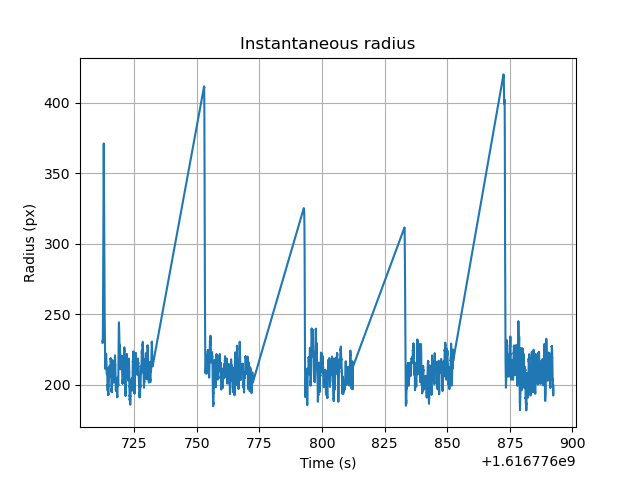

In [36]:
plt.figure()
plt.plot(time, radius)
plt.xlabel("Time (s)")
plt.ylabel("Radius (px)")
plt.title("Instantaneous radius")
plt.grid(True)
plt.show()